In [15]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools
from sklearn.svm import SVC
from sklearn.utils import shuffle
from scipy.stats import uniform
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the csv brain data with the significant variables
data = pd.read_csv("FAMatrixSignificantData.csv") 

# Shuffle the data
data = shuffle(data, random_state=0).reset_index(drop=True)
data.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column194,Column195,Column196,Column197,Column198,Column199,Column200,Column201,Column202,Column203
0,18.850784,16.402654,18.809981,18.661708,17.556558,12.513008,12.394331,19.063928,18.213575,14.936953,...,1.657895,1.052632,1.236842,1.447368,1.592105,1.434211,1.526316,1.434211,3.152472,ms
1,15.379834,15.053143,8.764925,16.539648,11.803099,14.081771,6.939545,16.653606,17.968536,10.570490,...,1.526316,1.144737,1.355263,1.447368,1.657895,1.460526,1.618421,1.565789,3.384429,ms
2,20.370230,14.767954,17.956064,19.209180,16.895640,13.473179,11.476377,19.414162,19.302838,14.640634,...,1.644737,1.092105,1.342105,1.421053,1.644737,1.460526,1.565789,1.486842,3.079077,ms
3,18.350076,17.712715,10.683727,16.155753,12.640386,15.522073,12.730161,21.097650,18.544670,12.890302,...,1.552632,1.092105,1.197368,1.342105,1.526316,1.460526,1.407895,1.486842,3.029070,ms
4,19.878999,20.705387,16.227605,22.664699,16.868130,17.093917,13.377150,19.524878,19.175979,15.947954,...,1.578947,1.052632,1.342105,1.407895,1.631579,1.578947,1.473684,1.434211,2.998180,ms


In [3]:
# Separate the dataframe into nodes_properties (x) and classes (y)
nodes_properties = data.iloc[:,0:len(data.columns)-1]
print('Properties dimensions: ', nodes_properties.shape)

classes = data.iloc[:,len(data.columns)-1]
classes_names = ["hv", "ms"]
n_classes = len(classes_names)
print('Classes dimensions: ', classes.shape)
print('There are {} classes: {}'.format(n_classes, classes_names))

Properties dimensions:  (239, 202)
Classes dimensions:  (239,)
There are 2 classes: ['hv', 'ms']


In [4]:
# Divide the dataframe in the test and train sets, with 80% of the data in the train group and 20% in the test set.
# We will stratify using classes, so that there is the same proportion of each class in the test/train sets as in the original
# dataset
X_train, X_test, y_train, y_test = train_test_split(nodes_properties, classes, test_size=0.2, random_state=2019, stratify=classes)


In [5]:
print('X_train dimensions: ', X_train.shape)
print('y_train dimensions: ', y_train.shape)

print('X_test dimensions: ', X_test.shape)
print('y_test dimensions: ', y_test.shape)

X_train dimensions:  (191, 202)
y_train dimensions:  (191,)
X_test dimensions:  (48, 202)
y_test dimensions:  (48,)


# K-NN

#### Hyperparameter tuning

In [6]:
# First of all, create the classifier
knn = KNeighborsClassifier()

# Then, the hyperparameters to be optimized are defined 
# k = number of nearest neighbours considered
# weights = weight function used in prediction. If it is 'uniform', all the neighbours will have the same importance. If it is 
# 'distance', closer neighbours will have more influence. 

k_range = list(range(1, 21))
weight_names = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights = weight_names)

# Now create the grid search with 4 folds for cross-validation
grid = GridSearchCV(knn, param_grid, cv=4, iid=False)

# Apply the grid to the data checking the time 
start = time()
grid.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(grid.cv_results_['rank_test_score'])
means = list(grid.cv_results_["mean_test_score"])
stds = list(grid.cv_results_["std_test_score"])
params = list(grid.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))


The search took 3.181504011154175 seconds
 
Rank : 1. Mean accuracy 84.8183 +/- 4.7384. Parameters: {'n_neighbors': 14, 'weights': 'distance'}


##### Model training with best parameters

In [7]:
# First create and fit the model with the best hyperparameters
knn = KNeighborsClassifier(n_neighbors=grid.best_params_["n_neighbors"], weights=grid.best_params_["weights"])

knn.fit(X_train, y_train)

# Predict the test values
y_predicted = knn.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("K-NN Algorithm results")
print("-----------------------")
print("Optimal k: {}".format(grid.best_params_["n_neighbors"]))
print("Optimal weights: {}".format(grid.best_params_["weights"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

K-NN Algorithm results
-----------------------
Optimal k: 14
Optimal weights: distance
Accuracy in the test set with the optimal parameters: 75.00%


In [8]:
# Confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

##### Confusion matrix

[[ 2  7]
 [ 5 34]]


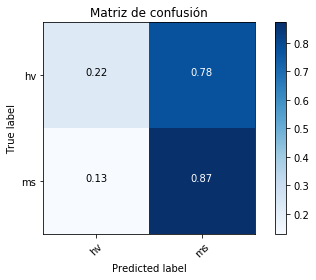

In [9]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')

# SVM

 ##### Hyperparameter tuning

In [10]:
# Create the classifier
svm_clasif = SVC(random_state = 1)

# Define the hyperparameters to be optimized
param_dist = dict(C=uniform(1, 100), gamma=uniform(0.001, 1))

# Now create the randomnized search with 4 folds for cross-validation
num_iterations = 100
cv = StratifiedKFold(n_splits=4, shuffle=True)
rand = RandomizedSearchCV(svm_clasif, param_distributions = param_dist, cv=cv, n_iter=num_iterations)

# Apply the search to the data checking the time 
start = time()
rand.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(rand.cv_results_['rank_test_score'])
means = list(rand.cv_results_["mean_test_score"])
stds = list(rand.cv_results_["std_test_score"])
params = list(rand.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))

The search took 9.802473068237305 seconds
 
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 89.44181231690317, 'gamma': 0.0636904189190477}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 68.89346874973006, 'gamma': 0.14212943642873654}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 16.833140582132053, 'gamma': 0.8034954329307321}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 38.464252066393556, 'gamma': 0.04012560318219538}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 12.423143005739833, 'gamma': 0.5158635533564009}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 31.271323574773103, 'gamma': 0.24925908655470452}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 42.77815956053846, 'gamma': 0.8777513337137806}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 31.336571993075346, 'gamma': 0.8187887252352003}
Rank : 1. Mean accuracy 81.1518 +/- 0.1718. Parameters: {'C': 77.943

#### Train model with best parameters

In [11]:
# Create and fit the model with the best hyperparameters
svm_clasif = SVC(C=rand.best_params_["C"], gamma=rand.best_params_["gamma"])
svm_clasif.fit(X_train, y_train)

# Predict the test values
y_predicted = svm_clasif.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("SVM Algorithm results")
print("-----------------------")
print("Optimal C: {}".format(rand.best_params_["C"]))
print("Optimal gamma: {}".format(rand.best_params_["gamma"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

SVM Algorithm results
-----------------------
Optimal C: 89.44181231690317
Optimal gamma: 0.0636904189190477
Accuracy in the test set with the optimal parameters: 81.25%


#### Confusion matrix

[[ 0  9]
 [ 0 39]]


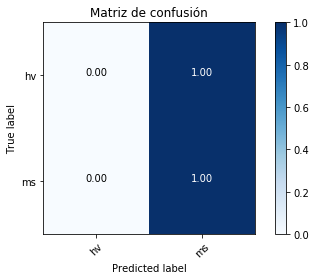

In [12]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')

# Random Forest

#### Hyperparameter tuning

In [17]:
# Create the classifier
random_forest = RandomForestClassifier(random_state=0)

# Define the hyperparameters to be optimized 
n_estimators = list(range(1, 61))
max_depth = range(1, 100, 10)

param_grid = dict(n_estimators=n_estimators, max_depth = max_depth)

# Create the grid search with 4 folds for cross-validation
grid = GridSearchCV(random_forest, param_grid, cv=4, iid=False)

# Apply the grid to the data checking the time 
start = time()
grid.fit(X_train, y_train)
end = time()

# Check the results
print("The search took {} seconds".format(end - start))
print(" ")

ranks = list(grid.cv_results_['rank_test_score'])
means = list(grid.cv_results_["mean_test_score"])
stds = list(grid.cv_results_["std_test_score"])
params = list(grid.cv_results_['params'])

results = zip (ranks, means, stds, params)
for rank, mean, std, params in results:
    if rank == 1: #If the rank of the result is one, print it
        print("Rank : {}. Mean accuracy {:.4f} +/- {:.4f}. Parameters: {}".format(rank, mean*100, std*100, params))


The search took 123.60973000526428 seconds
 
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 11, 'n_estimators': 51}
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 21, 'n_estimators': 51}
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 31, 'n_estimators': 51}
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 41, 'n_estimators': 51}
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 51, 'n_estimators': 51}
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 61, 'n_estimators': 51}
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 71, 'n_estimators': 51}
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 81, 'n_estimators': 51}
Rank : 1. Mean accuracy 82.1919 +/- 1.1501. Parameters: {'max_depth': 91, 'n_estimators': 51}


#### Train model with best hyperparameters

In [24]:
# Create and fit the model with the best hyperparameters
random_forest = RandomForestClassifier(random_state=0, n_estimators=grid.best_params_["n_estimators"], max_depth=grid.best_params_["max_depth"])
random_forest.fit(X_train, y_train)

# Predict the test values
y_predicted = random_forest.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_predicted)

# Print the results
print("Random Forest Algorithm results")
print("-----------------------")
print("Optimal n_estimators: {}".format(grid.best_params_["n_estimators"]))
print("Optimal max_depth: {}".format(grid.best_params_["max_depth"]))
print("Accuracy in the test set with the optimal parameters: {:.2f}%".format(accuracy*100))

Random Forest Algorithm results
-----------------------
Optimal n_estimators: 51
Optimal max_depth: 11
Accuracy in the test set with the optimal parameters: 81.25%


#### Confusion Matrix

[[ 1  8]
 [ 1 38]]


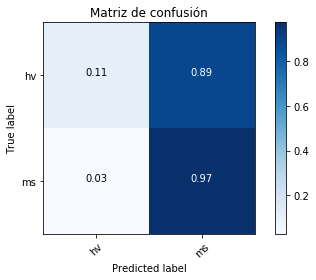

In [28]:
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes_names,
                      title='Matriz de confusión')